<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Parsa Norouzinezhad

**Student ID**: 4001021822





## Importing Libraries

First we import libraries that we need for this assignment.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
# import any other libraries needed below

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [2]:


data = pd.read_csv('data_logistic.csv')

X = data[['X1', 'X2', 'X3']].values
Y = data['Y'].values.reshape(-1, 1) 
print(X.shape)
print(Y.shape)


(10000, 3)
(10000, 1)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**: normalization is crucial to ensure that all features contribute equally to the model's decision-making process. Without normalization, features with larger scales or variances can dominate the training process, leading to biased parameter estimates and potentially inaccurate predictions. Normalizing the data brings all features to a similar scale, preventing this issue and helping the model learn more effectively from the data.

In [3]:


X_norm = (X - np.mean(X, axis=0)) / (np.std(X, axis=0))
Y_norm = (Y - np.mean(Y, axis=0)) / (np.std(Y, axis=0))


Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [6]:
X = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

print("X:", X)

X: [[ 1.         -1.00066149 -0.60536985 -0.85021999]
 [ 1.         -1.45366949  1.73051062 -0.20238503]
 [ 1.          0.26239007  1.69140966  0.64234794]
 ...
 [ 1.          1.35418019 -0.1188587   1.41249602]
 [ 1.          1.41727838  0.76498604  0.94404812]
 [ 1.          0.79312016  1.49592029  0.85670437]]


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [8]:
import numpy as np

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

test_scalar = sigmoid(0)
print("Sigmoid of scalar 0:", test_scalar)

test_vector = sigmoid(np.array([-1, 0, 1]))
print("Sigmoid of vector [-1, 0, 1]:", test_vector)

test_matrix = sigmoid(np.array([[-1, 0], [0, 1]]))
print("Sigmoid of matrix [[-1, 0], [0, 1]]:")
print(test_matrix)


Sigmoid of scalar 0: 0.5
Sigmoid of vector [-1, 0, 1]: [0.26894142 0.5        0.73105858]
Sigmoid of matrix [[-1, 0], [0, 1]]:
[[0.26894142 0.5       ]
 [0.5        0.73105858]]


### Cost Function 
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [23]:
def compute_cost(X, y, theta, reg_lambda=0):
  
    m = len(y) 
    h = sigmoid(np.dot(X, theta))
    cost = (-1 / m) * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))
    regularization_term = (reg_lambda / (2 * m)) * np.sum(np.square(theta[1:]))

    J = cost + regularization_term

    return J


### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:  
To compute the gradient of the cost function for the $j^{th}$ element ($j = 1, ..., d$),
This formula consists of two parts:

The first part calculates the gradient of the cost function without regularization, similar to the standard logistic regression gradient. It sums over all instances and multiplies the difference between the predicted value and the actual label by the $j^{th}$ feature of each instance $x_j^{(i)}$.
The second part adds the regularization term to the gradient. For all $j \neq 0$, it adds the term $\frac{\lambda}{m}\theta_j$, which penalizes large parameter values to prevent overfitting. However, for $j = 0$, corresponding to the bias term, we do not regularize the gradient.
This calculation ensures that we update the parameters in the direction that minimizes the cost function while also preventing overfitting by penalizing large parameter values.

In [10]:
def compute_gradient(X, y, theta, reg_lambda=0):

    m = len(y) 
    h = sigmoid(np.dot(X, theta))
    grad = (1 / m) * np.dot(X.T, (h - y))
    regularization_term = (reg_lambda / m) * theta
    regularization_term[0] = 0 
    grad += regularization_term.reshape(-1, 1)

    return grad


### Training and Prediction
Once you have the cost and gradient functions complete, implemen tthe fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [16]:
def fit(X, y, alpha=0.01, reg_lambda=0, epsilon=1e-4, max_iterations=1000):

    m, n = X.shape 
    theta = np.zeros((n, 1))  
    loss_history = []  

    for _ in range(max_iterations):
        grad = compute_gradient(X, y, theta, reg_lambda)

        theta_new = theta - alpha * grad

        if np.linalg.norm(theta_new - theta) <= epsilon:
            break


        theta = theta_new
        loss = compute_cost(X, y, theta, reg_lambda)
        loss_history.append(loss)

    return theta, np.array(loss_history)

def hasConverged(theta_old, theta_new, epsilon):

    return np.linalg.norm(theta_new - theta_old) <= epsilon


Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [17]:
theta, loss_history = fit(X, Y_norm)

print("Loss of each iteration:")
for loss in (loss_history):
    print( loss.item())

print("\nFinal parameters (theta):")
print(theta)


Loss of each iteration:
0.6844231894574292
0.6757430883701184
0.667106650349312
0.6585136448191102
0.6499638377102954
0.6414569915945156
0.6329928658186106
0.6245712166389098
0.6161917973553422
0.6078543584452076
0.5995586476964484
0.591304410340286
0.5830913891830724
0.5749193247372236
0.5667879553511069
0.5586970173377508
0.5506462451022645
0.5426353712678487
0.5346641268002955
0.5267322411308664
0.518839442277464
0.5109854569639992
0.5031700107378735
0.49539282808549645
0.4876536325457718
0.47995214682147674
0.47228809288848445
0.4646611921027646
0.45707116530512387
0.4495177329236322
0.4420006150737039
0.43451953165579654
0.42707420245070027
0.41966434721239576
0.4122896857584603
0.40494993805800816
0.39764482431715675
0.390374065062013
0.38313738121917656
0.3759344941937653
0.36876512594496574
0.36162899905912277
0.35452583682037475
0.3474553632788572
0.3404173033164878
0.33341138271035886
0.32643732819375937
0.31949486751485195
0.3125837294930372
0.305703644073032
0.2988543423766

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [51]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.33, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_valid:", Y_valid.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (7000, 4)
Shape of X_valid: (2010, 4)
Shape of X_test: (990, 4)
Shape of Y_train: (7000, 1)
Shape of Y_valid: (2010, 1)
Shape of Y_test: (990, 1)


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [19]:
def predict(X, theta):
    predictions = sigmoid(np.dot(X, theta))
    return predictions

def calculate_loss(predictions, y):
    m = len(y)
    loss = (-1 / m) * (np.dot(y.T, np.log(predictions)) + np.dot((1 - y).T, np.log(1 - predictions)))
    return loss.item()

predictions_test = predict(X_test, theta)

loss_test = calculate_loss(predictions_test, Y_test)

print("Loss on test set:", loss_test)


Loss on test set: -3.399259347791012


Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**: 

Learning Rate:
The learning rate controls the step size of the parameter updates during gradient descent. A smaller learning rate allows for more precise updates but may lead to slower convergence. Conversely, a larger learning rate can speed up convergence but may risk overshooting the optimal solution or causing instability. Typically, it's best to start with a small learning rate and gradually increase it if the training progress is too slow.

Regularization Constant:
The regularization constant helps prevent overfitting by penalizing large parameter values. A smaller regularization constant allows the model to fit the training data more closely but may lead to overfitting. Conversely, a larger regularization constant encourages simpler models and helps prevent overfitting. The choice of the regularization constant depends on the complexity of the data and the desired trade-off between bias and variance.

To find the best values of these parameters, the code iterates through different combinations of learning rates and regularization constants, evaluates the model's performance on a validation set, and selects the combination that yields the highest accuracy.

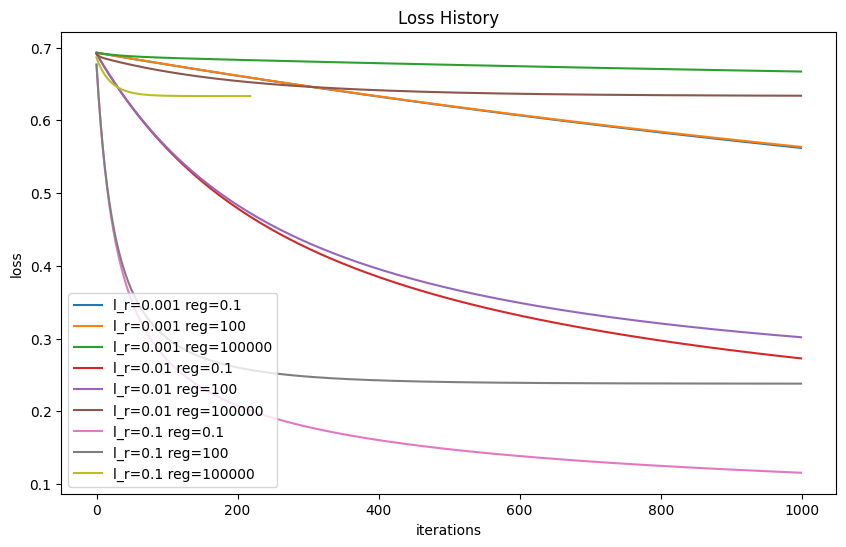

In [78]:
learning_rates = [0.001,0.01,0.1]
regularization_constants = [0.1 ,100, 100000]
best_accuracy=0
all_loss = []
results=[]
best_reg=0
best_LR=0
for l_r in learning_rates:
    for reg in regularization_constants:
        theta, loss = fit(X_train, Y_train,l_r, reg)
        loss2=[]
        for i in loss:
            loss2.append(i[0][0])
        all_loss.append(loss2)

plt.figure(figsize=(10, 6))
for i in range(len(all_loss)):
    label = "l_r="+str(learning_rates[i//3])+" reg="+str(regularization_constants[i % 3])
    plt.plot(all_loss[i],label=label)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss History')
plt.legend()
plt.show()


## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: Accuracy: 0.928

In [72]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy of Gaussian Naive Bayes:", accuracy)


Accuracy of Gaussian Naive Bayes: 0.9282828282828283


c:\Users\parsa nrz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: Accuracy: 0.985

In [75]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
y_pred = lda.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy of LDA:", accuracy)


Accuracy of LDA: 0.9848484848484849


c:\Users\parsa nrz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: LDA has the bst accuracy for this data set: 0.985 but other classifiers are useful too.  